In [1]:
import math
import torch

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector

from mmcv.parallel import collate, scatter
from mmcv.ops import RoIPool
from mmcv import Config, DictAction
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

## 1. Init Your config and model

In [2]:
config = '../work_dirs/yolo_v3/yolo_v3.py'
cfg = Config.fromfile(config)
checkpoint = '../work_dirs/yolo_v3/latest.pth'
device = 'cuda:0'
model = init_detector(config, checkpoint, device)

load checkpoint from local path: ../work_dirs/yolo_v3/latest.pth


### modefy the label names

In [4]:
label_names = [
    'person bev', 'car bev', 'van bev', 'truck bev', 'bus bev',
    'person', 'car', 'aeroplane', 'bus', 'train', 'truck', 'boat',
    'bird', 'camouflage man'
]

## This is a choice, your can build your dataset here

In [5]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [6]:
data = []
for i, t in enumerate(data_loader):
    tmp = {}
    tmp['img'] = t['img']
    tmp['img_metas'] = t['img_metas'][0].data[0]
    data.append(tmp)

## Visualize an image

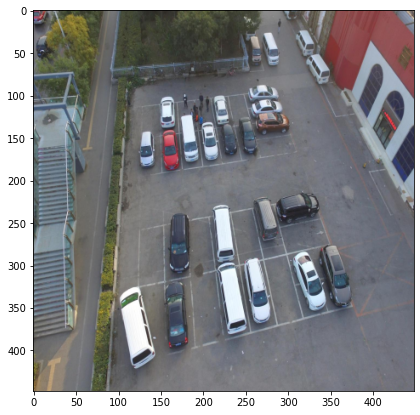

In [24]:
image_path = "/home/cry/data4/Datasets/js-dataset/images/9999962_00000_d_0000088.jpg"
image = cv2.imread(image_path)
# scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   dsize = (448, 448),
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

## Predict the results with Yolo V3

feature shape:torch.Size([1, 512, 20, 20])
0 person bev (288, 12, 292, 20) 0.8009196
0 person bev (185, 113, 192, 122) 0.60248697
0 person bev (196, 100, 201, 109) 0.5524444
0 person bev (176, 101, 181, 110) 0.40713525
1 car bev (256, 105, 296, 127) 0.9641007
1 car bev (254, 89, 291, 109) 0.9570686
1 car bev (304, 280, 348, 353) 0.9489557
1 car bev (198, 133, 218, 176) 0.93643373
1 car bev (150, 103, 167, 139) 0.9013307
1 car bev (261, 124, 303, 146) 0.89387417
1 car bev (285, 218, 336, 248) 0.88192564
1 car bev (213, 102, 230, 134) 0.7665907
1 car bev (151, 142, 172, 187) 0.75317365
1 car bev (244, 130, 264, 171) 0.72236955
1 car bev (222, 133, 240, 172) 0.7014237
1 car bev (125, 142, 142, 186) 0.59064424
1 car bev (154, 327, 186, 400) 0.448379
2 van bev (312, 25, 331, 54) 0.7886836
2 van bev (261, 218, 288, 271) 0.61978465
2 van bev (174, 130, 194, 178) 0.6090146
2 van bev (125, 142, 142, 186) 0.5484206
2 van bev (252, 29, 269, 66) 0.50153285
2 van bev (222, 133, 240, 172) 0.4212546


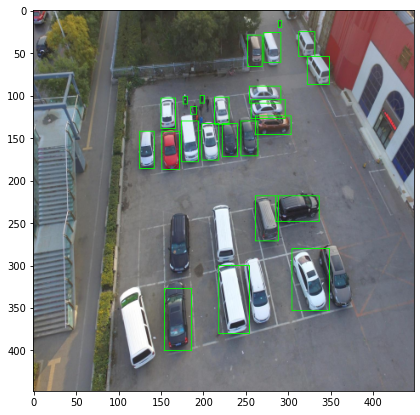

In [25]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.4:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

## 2. This is the core demo for Grad CAM

In [8]:
class GradCAM_YOLOV3(object):
    """
    Grad CAM for Yolo V3 in mmdetection framework
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, data, index=0):
        """
        :param image: cv2 format, single image
        :param index: Which bounding box
        :return:
        """
        self.net.zero_grad()
        # Important
        feat = self.net.extract_feat(data['img'][0].cuda())
        res = self.net.bbox_head.simple_test(
            feat, data['img_metas'][0], rescale=True)
        
        score = res[0][0][index][4]
       
        score.backward()

        gradient = self.gradient.cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))[0]  # [C]

        feature = self.feature.cpu().data.numpy().squeeze()[0]  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        cam = np.maximum(cam, 0)  # ReLU

        # Normalization
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        box = res[0][0][index][:-1].cpu().detach().numpy().astype(np.int32)
        
        class_id = res[0][1][index].cpu().detach().numpy()
        return cam, box, class_id

In [7]:
# GPU version
class GradCAM_YOLOV3(object):
    """
    Grad CAM for Yolo V3 in mmdetection framework
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, data, index=0):
        """
        :param image: cv2 format, single image
        :param index: Which bounding box
        :return:
        """
        self.net.zero_grad()
        # Important
        feat = self.net.extract_feat(data['img'][0].cuda())
        res = self.net.bbox_head.simple_test(
            feat, data['img_metas'][0], rescale=True)
        
        score = res[0][0][index][4]
       
        score.backward()

        gradient = self.gradient  # [C,H,W]
        weight = torch.mean(gradient, axis=(1, 2))[0]  # [C]

        feature = self.feature[0][0]  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = torch.sum(cam, axis=0)  # [H,W]
        cam = torch.relu(cam)  # ReLU

        # Normalization
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        # resize to 224*224
        box = res[0][0][index][:-1].cpu().detach().numpy().astype(np.int32)
        
        class_id = res[0][1][index].cpu().detach().numpy()
        return cam.cpu().detach().numpy(), box, class_id

## If you just an image in opencv format, this is a preparation function

In [8]:
def prepare_img(imgs):
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    cfg = model.cfg
    device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)
    print(datas)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        for m in model.modules():
            assert not isinstance(
                m, RoIPool
            ), 'CPU inference with RoIPool is not supported currently.'

    return data

## These functions are used for rendering images

In [9]:
def norm_image(image):
    """
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # mask to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    # heatmap = np.float32(heatmap) / 255
    # heatmap = heatmap[..., ::-1]  # gbr to rgb

    # merge heatmap to original image
    cam = 0.5 * heatmap + 0.5 * image
    return norm_image(cam), heatmap

## For grad-cam, you need to choose a layer in the backbone, you can choose one from the name list below

In [10]:
for name, m in model.named_modules():
    if isinstance(m, torch.nn.Conv2d):
        print(name,',',m)# backbone.conv_res_block5.res3.conv2.conv

backbone.conv1.conv , Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.conv_res_block1.conv.conv , Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
backbone.conv_res_block1.res0.conv1.conv , Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.conv_res_block1.res0.conv2.conv , Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.conv_res_block2.conv.conv , Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
backbone.conv_res_block2.res0.conv1.conv , Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.conv_res_block2.res0.conv2.conv , Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.conv_res_block2.res1.conv1.conv , Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.conv_res_block2.res1.conv2.conv , Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [11]:
# For example, you can choose 'backbone.conv_res_block4.conv.conv'
grad_cam = GradCAM_YOLOV3(model, 'backbone.conv_res_block4.conv.conv')

### Prepare an image

In [12]:
image_path = '/home/cry/data4/Datasets/js-dataset/images/0000008_02499_d_0000041.jpg'
image = cv2.imread(image_path)
data = prepare_img(image)

[{'img_metas': [DataContainer({'filename': None, 'ori_filename': None, 'ori_shape': (765, 1360, 3), 'img_shape': (180, 320, 3), 'pad_shape': (192, 320, 3), 'scale_factor': array([0.23529412, 0.23529412, 0.23529412, 0.23529412], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([0., 0., 0.], dtype=float32), 'std': array([255., 255., 255.], dtype=float32), 'to_rgb': True}})], 'img': [DataContainer(tensor([[[0.3490, 0.3451, 0.3373,  ..., 0.3569, 0.5059, 0.5020],
         [0.3373, 0.3490, 0.3412,  ..., 0.2039, 0.2235, 0.3765],
         [0.3569, 0.3529, 0.3647,  ..., 0.1647, 0.1804, 0.2196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4392, 0.4471, 0.4431,  ..., 0.3373, 0.5020, 0.5176],
         [0.4275, 0.4510, 0.4471,  ..., 0.1686, 0.1804, 0.3294],
         [0.4471, 0.4549, 0.4

/home/cry/anaconda3/envs/mmdet/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


### Get the mask through grad-cam

In [20]:
## First is the data, second is the index of the predicted bbox
mask, box, class_id = grad_cam(data,0)

feature shape:torch.Size([1, 512, 12, 20])


## Rendering the image

In [21]:
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
image_cam, heatmap = gen_cam(image, mask)

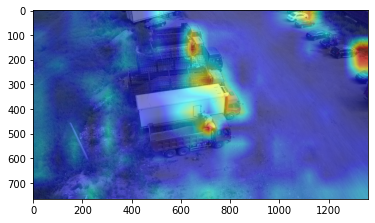

In [22]:
plt.imshow(image_cam[:, :, ::-1])

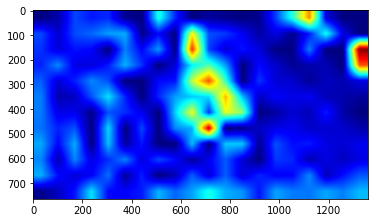

In [17]:
plt.imshow(heatmap[:, :, ::-1])

## Add bounding box

In [18]:
import random

def draw_label_type(draw_img,bbox,label, line = 5,label_color=None):
    if label_color == None:
        label_color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]

    # label = str(bbox[-1])
    labelSize = cv2.getTextSize(label + '0', cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
    if bbox[1] - labelSize[1] - 3 < 0:
        cv2.rectangle(draw_img,
                      bbox[:2],
                      bbox[2:],
                      color=label_color,
                      thickness=line
                      )
        # cv2.putText(draw_img, label,
        #             (bbox[0], bbox[1] + labelSize + 3),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             0.5,
        #             (0, 0, 0),
        #             thickness=1
        #             )
    else:
        cv2.rectangle(draw_img,
                      bbox[:2],
                      bbox[2:],
                      color=label_color,
                      thickness=line
                    #   thickness=-1
                      )
        # cv2.putText(draw_img, label,
        #             (bbox[0], bbox[1] - 3),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             0.5,
        #             (0, 0, 0),
        #             thickness=1
        #             )

In [19]:
draw_image = image_cam.copy()
## display with red
draw_label_type(draw_image,box,label_names[int(class_id)],line = 5,label_color=(0,0,255))

# Show the corresponding predicted box

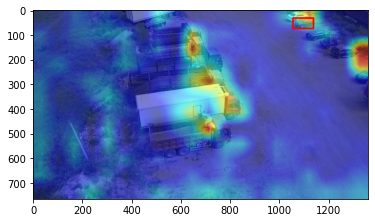

In [20]:
plt.imshow(draw_image[:, :, ::-1])